In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.ops import expand_dims
from keras.applications.resnet50 import ResNet50, preprocess_input

In [17]:
image_size = (224, 224)
batch_size = 50

train_ds, val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

classes = train_ds.class_names

Found 5544 files belonging to 12 classes.
Using 4436 files for training.
Using 1108 files for validation.


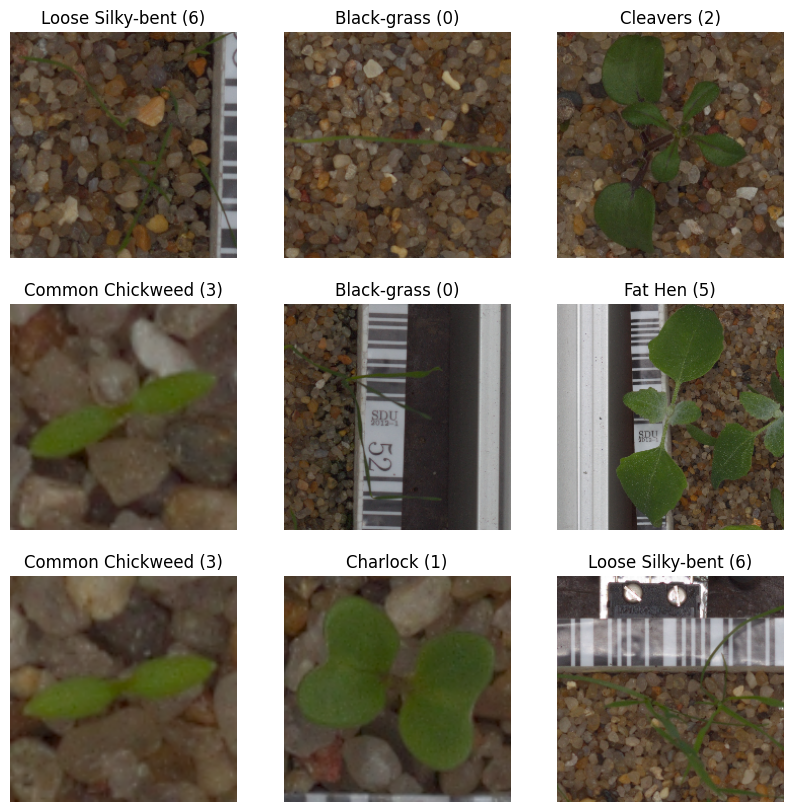

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        image = images[i].numpy().astype("uint8")
        label = np.argmax(labels[i])

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"{classes[label]} ({label})")
        plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [20]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

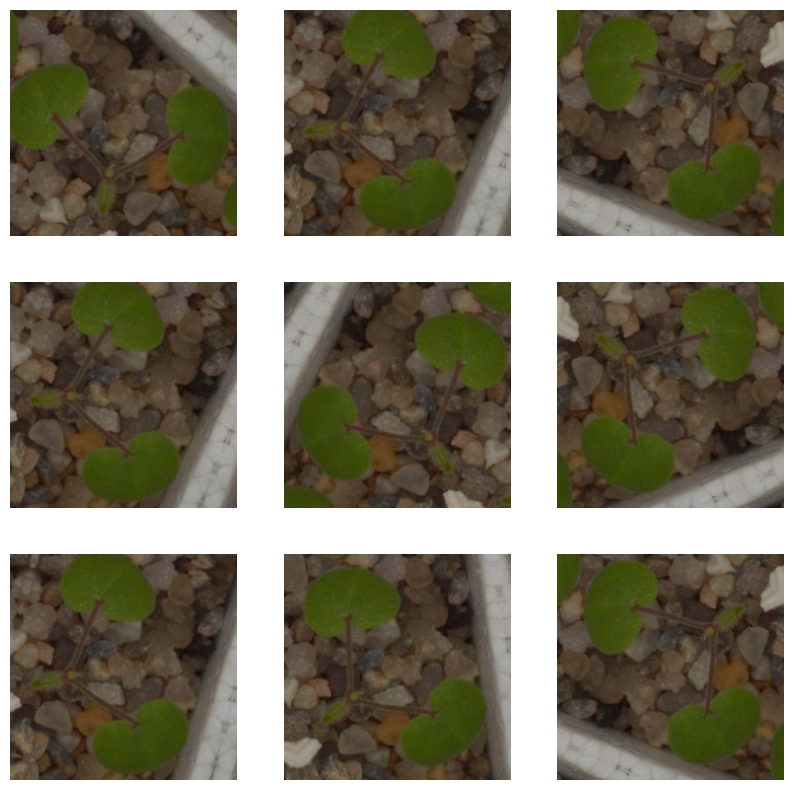

In [21]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [22]:
base_model = ResNet50(
    include_top=True,
    weights=None,
    classes=len(classes),
)

In [25]:
inputs = tf.keras.Input(shape=image_size + (3,), name="input_image")

x = data_augmentation(inputs)
x = preprocess_input(x)

outputs = base_model(x)

model = tf.keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ sequential_1[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ sequential_1[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ sequential_1[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 12)        │ 23,612,300 │ add_1[0][0]       │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 23,559,180 (89.87 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

In [ ]:
img = load_img("PetImages/Cat/10198.jpg", target_size=image_size)
plt.imshow(img)

img_array = img_to_array(img)
img_array = expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)